## Going to load the test data

In [1]:
import csv

data_folder = "./data"

lines = []

with open(data_folder + "/driving_log.csv", "r") as file:
    reader = csv.reader(file)
    for line in reader:
        lines.append(line)
print("There are", len(lines), "measurements.")
print("The data is in the following format:")
print("\tCenter Image | Left Image | Right Image | Steering | Throttle | Brake | Speed")

There are 18273 measurements.
The data is in the following format:
	Center Image | Left Image | Right Image | Steering | Throttle | Brake | Speed


# Data preprocessing:
1. Modify the paths of the images in the csv file so that this model can run on an EC2 instance with a GPU for training.
2. Crop all images so that only the road visible and not the sky.
3. Increase sample size by flipping all images in the the training set. There are less than 60k images and less than 20k steering measurements in this training set. It would be prudent to create some more using diferent transformations.
4. Shuffle the data

#### Going to visualize the images before they are modified 

In [2]:
from matplotlib import pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def display_images(left, center, right, lm, cm, rm):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)

    # Fine-tune figure; make subplots spaced out
    f.subplots_adjust(wspace = .3)
    f.set_size_inches(12, 5)

    ax1.imshow(left)
    ax1.set_title("Left: " + str(lm) + " degrees")
    ax2.imshow(center)
    ax2.set_title("Center: " + str(cm) + " degrees")
    ax3.imshow(right)
    ax3.set_title("Right: " + str(rm) + " degrees")
    plt.show()

In [3]:
import cv2
import numpy as np

# TODO: convert these values to numpy arrays because that is the format that keras requires
# images will hold the images
images = []

# measurements will hold the measured driving angle
measurements = []

# steering offset hyperparameter
offset = 0.2

300 images
(160, 320, 3)
300 measurements
-0.2507208


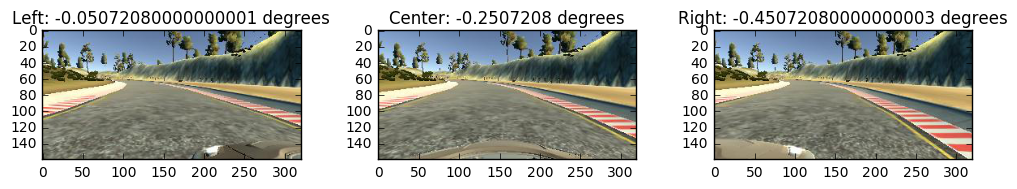

In [4]:
# Modifiying the paths of the images
count = 0
for line in lines:
    # images are in the following order: center, left, right
    for i in range(0, 3):
        source = line[i].split("\\")[-1]
        source = data_folder + "/IMG/" + source
        image = cv2.imread(source)
        # the image is originally opened in BGR, gonna have to change it to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
    center = float(line[3])
    left = center + offset
    right = center - offset
    measurements.append(center)
    measurements.append(left)
    measurements.append(right)
    count += 1
    if(count == 100):
        break;
print(len(images), "images")
print(images[0].shape)
print(len(measurements), "measurements")
print(measurements[0])

display_images(images[1], images[0], images[2], measurements[1], measurements[0], measurements[2])

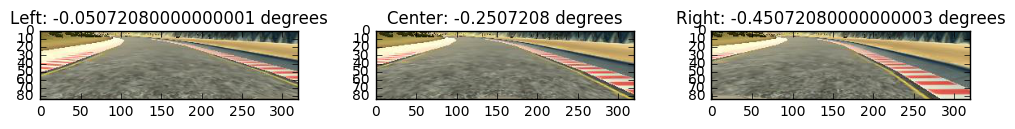

(85, 320, 3)


In [5]:
# cropping the images
def crop_image(image):
    cropped = image[55:140, 0:320]
    return cropped

cropped = []
for image in images:
    crop = crop_image(image)
    cropped.append(crop)

display_images(cropped[1], cropped[0], cropped[2], measurements[1], measurements[0], measurements[2])
print(cropped[0].shape)
image_shape = cropped[0].shape

#### going to convert the images and measurement lists into numpy arrays

In [6]:
images = np.array(cropped)
measurements = np.array(measurements)

There are 300 modified images.
There are 300 modified measurements.


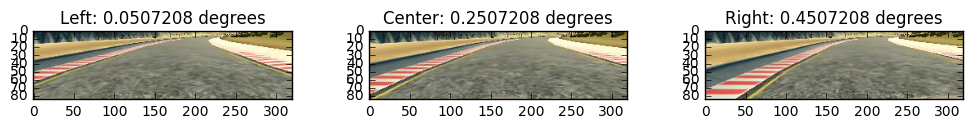

In [7]:
# going to flip all images here
modified_images = []
modified_measurements = []
for image in images:
    modified_images.append(cv2.flip(image, 1))

for measurement in measurements: 
    modified_measurements.append(-1 * measurement)

print("There are", len(modified_images), "modified images.")
print("There are", len(modified_measurements), "modified measurements.")

modified_images = np.array(modified_images)
modified_measurements = np.array(modified_measurements)

display_images(modified_images[1], modified_images[0], modified_images[2],modified_measurements[1], modified_measurements[0], modified_measurements[2])

In [8]:
images = np.append(images, modified_images, axis=0)
measurements = np.append(measurements, modified_measurements)

print("There are", len(images), "modified images.")
print("There are", len(measurements), "modified measurements.")

There are 600 modified images.
There are 600 modified measurements.


I now have 2X as many images and 6X as many measurements in my training set than I had before. However, it would be better if I applied a few transformations to the images to prevent overfitting and promote better generalization.

### Random shift (in case, I need more data)
According to Nvidia's paper "End to End Learning for Self-Driving Cars", we should consider the center of each lane to the "ground truth". Unfortunately, human drivers do not always drive in the center of the lane. 
So, we have to manually calibrate the lane center associated with each frame. We do this by transforming the original images to account for departures from the "ground truth". The steering label for transformed images is adjusted to one that would steer the vehicle back to the desired location and orientation in two seconds.

In [9]:
# Shuffle the data
from sklearn.utils import shuffle
images, measurements = shuffle(images, measurements)

# Data Visualization

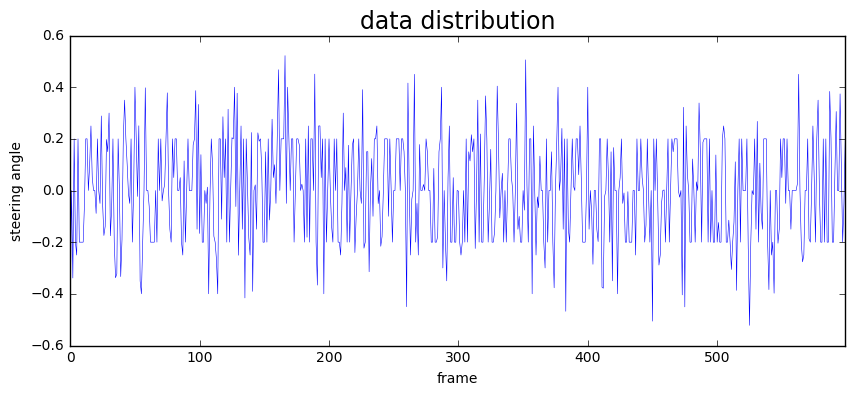

In [10]:
plt.figure(figsize=(10,4))
x = [range(len(measurements))]
x = np.squeeze(np.asarray(x))
y = np.asarray(measurements)
plt.xlim(0,len(measurements)-1)
plt.title('data distribution', fontsize=17)
plt.xlabel('frame')
plt.ylabel('steering angle')
plt.plot(x,y, '', linewidth=0.4)
plt.show()

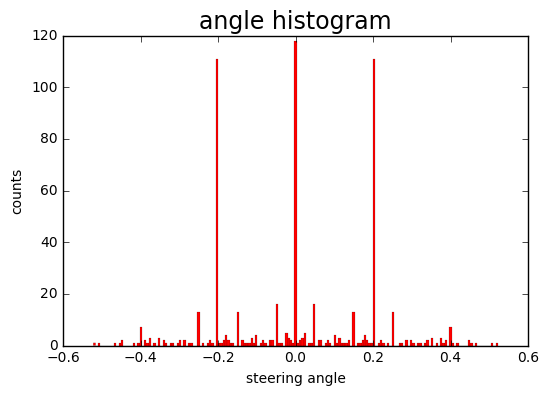

In [11]:
plt.hist(measurements, bins= len(np.unique(measurements)), color= 'red', linewidth=0.1)
plt.title('angle histogram', fontsize=17)
plt.xlabel('steering angle')
plt.ylabel('counts')
plt.show()

# Developing the model
I'm modelling my pipeline after GoogLenet. This means that I will make use of inception modules in my pipeline.

In [12]:
from keras.layers import Merge, merge
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Convolution2D
from keras.models import Sequential

# the following arrays define the number of filters for each part of an inception layer 
# for each of the inception layers
inception_layer1 = [64, 96, 128, 16, 32, 32]
inception_layer2 = [128, 128, 192, 32, 96, 64]
inception_layer3 = [192, 96, 208, 16, 48, 64]
inception_layer4 = [160, 112, 224, 24, 64, 64]
inception_layer5 = [128, 128, 256, 24, 64, 64]
inception_layer6 = [112, 144, 288, 32, 64, 64]
inception_layer7 = [256, 160, 320, 32, 128, 128]
inception_layer8 = [256, 160, 320, 32, 128, 128]
inception_layer9 = [384, 192, 384, 48, 128, 128]

# method to build the inception layers
# 3x3 reduce and 5x5 reduce stand for the number of 1x1 filters in the reduce layer used
# before the 3x3 and 5x5 filters
# this method adds 2 to the overall height of the model
def inception(input_value, num_filters):
    
    # 1x1 
    part1 = Convolution2D(num_filters[0], 1, 1, border_mode='same', activation='relu')(input_value)
    # 3x3 reduce
    part2 = Convolution2D(num_filters[1], 1, 1, border_mode='same', activation='relu')(input_value)
    # 3x3
    part2 = Convolution2D(num_filters[2], 3, 3, border_mode='same', activation='relu')(part2)
    # 5x5 reduce
    part3 = Convolution2D(num_filters[3], 1, 1, border_mode='same', activation='relu')(input_value)
    # 5x5
    part3 = Convolution2D(num_filters[4], 5, 5, border_mode='same', activation='relu')(part3)
    # maxpool
    part4 = MaxPooling2D((3, 3), strides=(1, 1), border_mode='same')(input_value)
    # pool projection
    part4 = Convolution2D(num_filters[5], 1, 1, border_mode='same', activation='relu')(part4)

    return merge([part1, part2, part3, part4], mode='concat', concat_axis=1)

def inceptionSeq(model, num_filters):
    
    part1 = Sequential()
    # 1x1 
    part1.add(Convolution2D(num_filters[0], 1, 1, border_mode='same', activation='relu'))
    
    part2 = Sequential()
    # 3x3 reduce
    part2.add(Convolution2D(num_filters[1], 1, 1, border_mode='same', activation='relu'))
    # 3x3
    part2.add(Convolution2D(num_filters[2], 3, 3, border_mode='same', activation='relu'))
    
    part3 = Sequential()
    # 5x5 reduce
    part3.add(Convolution2D(num_filters[3], 1, 1, border_mode='same', activation='relu'))
    # 5x5
    part3.add(Convolution2D(num_filters[4], 5, 5, border_mode='same', activation='relu'))
    
    part4 = Sequential()
    # maxpool
    part4.add(MaxPooling2D((3, 3), strides=(1, 1), border_mode='same'))
    # pool projection
    part4.add(Convolution2D(num_filters[5], 1, 1, border_mode='same', activation='relu'))

    model.add(Merge([part1, part2, part3, part4], mode='concat', concat_axis=1))

Using TensorFlow backend.


In [13]:
from keras.layers import Dropout, Flatten, Input
from keras.layers.pooling import AveragePooling2D
from keras.layers.core import Dense, Flatten, Dropout
from keras.models import Model

# method to build the pipeline
def build_GoogLenet():
    input_img = Input(shape=image_shape)
    
    # convolution: (7x7, stride = 2, 64 filters)
    layer1 = Convolution2D(64,7,7,subsample=(2,2),border_mode='same',activation='relu')(input_img)
    
    # maxpool: (3x3, stride = 2, border_mode = same or valid)
    layer1 = MaxPooling2D((3, 3), strides=(2, 2), border_mode='same')(layer1)
    
    # 3x3 reduce convolution: (1x1, stride = 1, 64 filters)
    layer2 = Convolution2D(num_filters[1], 1, 1, border_mode='same', activation='relu')(layer1)
    # convolution: (3x3, stride = 1, 192 filters)
    layer2 = Convolution2D(192, 3, 3, border_mode='same', activation='relu')(layer2)
    
    # maxpool: (3x3, stride = 2, border_mode = same or valid)
    layer2 = MaxPooling2D((3, 3), strides=(2, 2), border_mode='same')(layer2)
    
    # inception module 1
    layer3 = inception(layer2, inception_layer1)
    
    # inception module 2
    layer4 = inception(layer3, inception_layer2)
    
    # maxpool: (3x3, stride = 2, border_mode = same or valid)
    layer4 = MaxPooling2D((3, 3), strides=(2, 2), border_mode='same')(layer4)
    
    #inception module 3
    layer5 = inception(layer4, inception_layer3)
    
    #inception module 3
    layer6 = inception(layer5, inception_layer4)
    
    #inception module 3
    layer7 = inception(layer6, inception_layer5)
    
    #inception module 3
    layer8 = inception(layer7, inception_layer6)
    
    #inception module 3
    layer9 = inception(layer8, inception_layer7)
    
    # maxpool: (3x3, stride = 2, border_mode = same or valid)
    layer10 = MaxPooling2D((3, 3), strides=(2, 2), border_mode='same')(layer9)
    
    #inception module 3
    layer11 = inception(layer10, inception_layer8)
    
    #inception module 3
    layer12 = inception(layer11, inception_layer9)
    
    # average pooling: (7x7, stride = 1)
    layer13 = AveragePooling2D(pool_size=(7,7),strides=(1,1))(layer12)
    
    # dropout: 40%
    layer14 = Dropout(0.4)(layer13)
    
    # Flatten
    layer15 = Flatten()(layer14)
    
    # Dense layer
    layer16 = Dense(1)(layer15)
    
    layer17 = Activation('softmax')(layer16)
    
    model = Model(input=input_img, output = layer17)
    
    return model

In [ ]:
def build_GoogLenetSeq():
    model = Sequential()
    
    # convolution: (7x7, stride = 2, 64 filters)
    model.add(Convolution2D(64,7,7,subsample=(2,2),border_mode='same',activation='relu', input_shape = image_shape))
    
    # maxpool: (3x3, stride = 2, border_mode = same or valid)
    model.add(MaxPooling2D((3, 3), strides=(2, 2), border_mode='same'))
    
    # 3x3 reduce convolution: (1x1, stride = 1, 64 filters)
    model.add(Convolution2D(num_filters[1], 1, 1, border_mode='same', activation='relu'))
    # convolution: (3x3, stride = 1, 192 filters)
    model.add(Convolution2D(192, 3, 3, border_mode='same', activation='relu'))
    
    # maxpool: (3x3, stride = 2, border_mode = same or valid)
    model.add(MaxPooling2D((3, 3), strides=(2, 2), border_mode='same'))
    
    # inception module 1
    # layer3 = inception(layer2, inception_layer1)
    inceptionSeq(model, inception_layer1)
    
    # inception module 2
    inceptionSeq(model, inception_layer2)
    
    # maxpool: (3x3, stride = 2, border_mode = same or valid)
    model.add(MaxPooling2D((3, 3), strides=(2, 2), border_mode='same')(layer4)
    
    #inception module 3
    inceptionSeq(model, inception_layer3)
    
    #inception module 3
    inceptionSeq(model, inception_layer4)
    
    #inception module 3
    inceptionSeq(model, inception_layer5)
    
    #inception module 3
    inceptionSeq(model, inception_layer6)
    
    #inception module 3
    inceptionSeq(model, inception_layer7)
    
    # maxpool: (3x3, stride = 2, border_mode = same or valid)
    model.add(MaxPooling2D((3, 3), strides=(2, 2), border_mode='same'))
    
    #inception module 3
    inceptionSeq(model, inception_layer8)
    
    #inception module 3
    inceptionSeq(model, inception_layer9)
    
    # average pooling: (7x7, stride = 1)
    model.add(AveragePooling2D(pool_size=(7,7),strides=(1,1)))
    
    # dropout: 40%
    model.add(Dropout(0.4))
    
    # Flatten
    model.add(Flatten())
    
    # Dense layer
    model.add(Dense(1))
    
    model.add(Activation('softmax'))
              
    